<a href="https://colab.research.google.com/github/MaxGhenis/random/blob/master/global_lfpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Labor Force Participation Rate and GDP per capita

Evaluating Andrew Yang's comparison of the US to Latin American countries.

## Setup

In [1]:
!pip install wbdata
# Install latest, since Colab is just on 0.7.
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [2]:
import wbdata
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Chart options

In [3]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

--2019-03-03 17:47:24--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2019-03-03 17:47:24--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/Roboto-Regular.ttf.1’

Roboto-Regular.ttf. 100%[===================>] 141.94K  --.-KB/s    in 0.04s   

2019-03-03 17:47:

In [0]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

## Load data

In [0]:
indicators = {'SP.DYN.LE00.IN': 'life_expectancy',
              'SL.TLF.CACT.ZS': 'lfpr',
              'SL.TLF.ACTI.ZS': 'lfpr1564',
              'NY.GDP.PCAP.PP.CD': 'gdppcppp',
              'SP.POP.TOTL': 'pop'}
wbdf = wbdata.get_dataframe(indicators).reset_index()

Remove aggregates.

In [6]:
geos = pd.Series(wbdf.country.unique())
world_index = geos[geos == 'World'].index[0]
aggs = geos[:world_index+1]
wbdf = wbdf[~wbdf.country.isin(aggs)]
wbdf.head()

,country,date,gdppcppp,lfpr,lfpr1564,life_expectancy,pop
2773,Afghanistan,2018,NaN,54.242001,55.750000,NaN,NaN
2774,Afghanistan,2017,1972.178018,54.237999,55.742001,NaN,35530081.0
2775,Afghanistan,2016,1934.616840,54.234001,55.731998,63.673,34656032.0
2776,Afghanistan,2015,1918.938459,53.907001,55.375999,63.288,33736494.0
2777,Afghanistan,2014,1927.087320,53.382999,54.820000,62.895,32758020.0


Add year.

In [0]:
wbdf['year'] = wbdf.date.astype(int)
wbdf.drop('date', inplace=True, axis=1)

Determine the latest year for each indicator.

In [8]:
def latest_year(col):
    return wbdf[~wbdf[col].isnull()].year.max()

INDICATORS = ['gdppcppp', 'lfpr', 'lfpr1564', 'life_expectancy', 'pop']

latest_years = pd.DataFrame({
    'indicator': INDICATORS,
    'latest_year': [latest_year(i) for i in INDICATORS]
})

latest_years

,indicator,latest_year
0,gdppcppp,2017
1,lfpr,2018
2,lfpr1564,2018
3,life_expectancy,2016
4,pop,2017


In [0]:
country = pd.DataFrame({'country': wbdf.country.unique()})

for i in INDICATORS:
    tmp = wbdf[wbdf.year == latest_year(i)][['country', i]]
    country = country.merge(tmp, on='country')
    
country.dropna(inplace=True)

In [0]:
TARGET_COUNTRIES = ['United States', 'Ecuador', 'Costa Rica', 'El Salvador',
                    'Dominican Republic']
country['is_target'] = country.country.isin(TARGET_COUNTRIES)
country['alpha'] = np.where(country.is_target, 1.0, 0.7)

In [0]:
country['lfpr_rank'] = country.lfpr.rank()
country['lfpr_pr'] = country.lfpr_rank / country.shape[0]
country['lfpr1564_rank'] = country.lfpr1564.rank()
country['lfpr1564_pr'] = country.lfpr1564_rank / country.shape[0]

In [48]:
country[(country.is_target)][['country', 'life_expectancy']]

,country,life_expectancy
46,Costa Rica,79.831000
56,Dominican Republic,73.861000
57,Ecuador,76.327000
59,El Salvador,73.512000
206,United States,78.690244


In [53]:
country[(country.is_target)][['country', 'lfpr1564', 'lfpr1564_pr']]

,country,lfpr1564,lfpr1564_pr
46,Costa Rica,66.271004,0.350575
56,Dominican Republic,71.052002,0.551724
57,Ecuador,71.037003,0.545977
59,El Salvador,65.733002,0.321839
206,United States,71.750999,0.591954


In [0]:
country[(country.is_target) | (country.country.isin(['United Kingdom', 'Sweden']))][['country', 'lfpr', 'lfpr_pr']]

In [47]:
country[(country.is_target) | (country.country.isin(['United Kingdom', 'Sweden']))][['country', 'lfpr', 'lfpr_pr']]

,country,lfpr,lfpr_pr
46,Costa Rica,59.647999,0.385057
56,Dominican Republic,66.688004,0.655172
57,Ecuador,67.983002,0.706897
59,El Salvador,61.716000,0.465517
187,Sweden,64.082001,0.557471
205,United Kingdom,62.340000,0.488506
206,United States,61.620998,0.459770


In [0]:
palette = {True: '#1565c0', False: '#bdbdbd'}
alphas = country.alpha.sort_values().unique()

In [0]:
def translate_size(min_x, max_x, min_y, max_y, val):
    return min_y + (val - min_x) * (max_y - min_y) / (max_x - min_x)

In [0]:
MIN_SIZE, MAX_SIZE = 20, 1000
min_size_target = translate_size(
    country[~country.is_target]['pop'].min(),
    country[~country.is_target]['pop'].max(),
    MIN_SIZE, MAX_SIZE,
    country[country.is_target]['pop'].min())
max_size_target = translate_size(
    country[~country.is_target]['pop'].min(),
    country[~country.is_target]['pop'].max(),
    MIN_SIZE, MAX_SIZE,
    country[country.is_target]['pop'].max())

In [0]:
labels = {'lfpr': 'labor force participation rate, aged 15+',
          'lfpr1564': 'labor force participation rate, aged 15-64',
          'life_expectancy': 'life expectancy',
          'gdppcppp': 'GDP per capita, PPP'}

In [0]:
title_labels = {'lfpr': 'Labor force participation rate, aged 15+',
                'lfpr1564': 'Labor force participation rate, aged 15-64',
                'life_expectancy': 'Life expectancy',
                'gdppcppp': 'GDP per capita, PPP'}

In [0]:
def chart(x, y, show_labels):
    ax = sns.scatterplot(x=x, y=y, size='pop', hue='is_target',
                         palette=palette, sizes=(MIN_SIZE, MAX_SIZE), 
                         data=country[country.alpha == alphas[0]],
                         alpha=alphas[0])

    # Use a general solution.
    for alpha in alphas[1:]:
        sns.scatterplot(x=x, y=y, size='pop', hue='is_target',
                        palette=palette, 
                        sizes=(min_size_target, max_size_target),
                        data=country[country.alpha == alpha],
                        alpha=alpha, ax=ax)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',') + '%'))

    if y == 'gdppcppp':
        ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
        
    if (y == 'lfpr') or (y == 'lfpr1564'):
        ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',') + '%'))
    
    ax.set(xlabel=title_labels[x] + ' (' + str(latest_year(x)) + ')',
           ylabel=title_labels[y] + ' (' + str(latest_year(y)) + ')')

    plt.title(title_labels[x] + ' vs. ' + labels[y], 
              loc='left')

    ax.grid(color='#f5f5f5')

    if show_labels:
        for index, row in country[country.is_target].iterrows():
             ax.text(row[x] + 1 + row['pop'] / 5e8, row[y] - 0.4,
                     row.country,
                     horizontalalignment='left', size=10, color=palette[True])
        ax.text(country[x].max(), country[y].min(), '@MaxGhenis',
                horizontalalignment='right', size=8, color=palette[False])

    sns.despine(left=True, bottom=True)
    ax.get_legend().remove()
    plt.show()

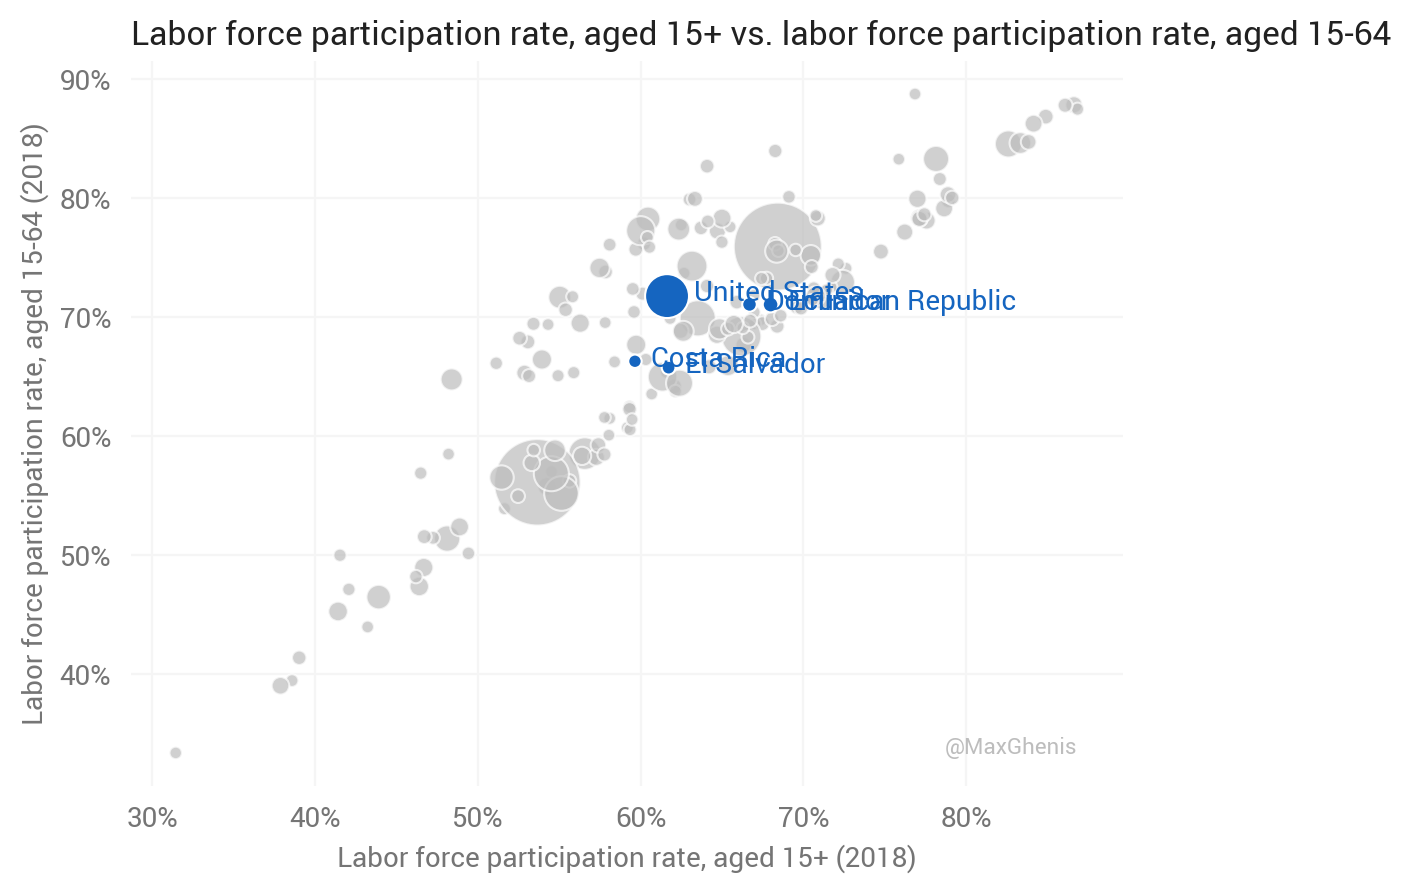

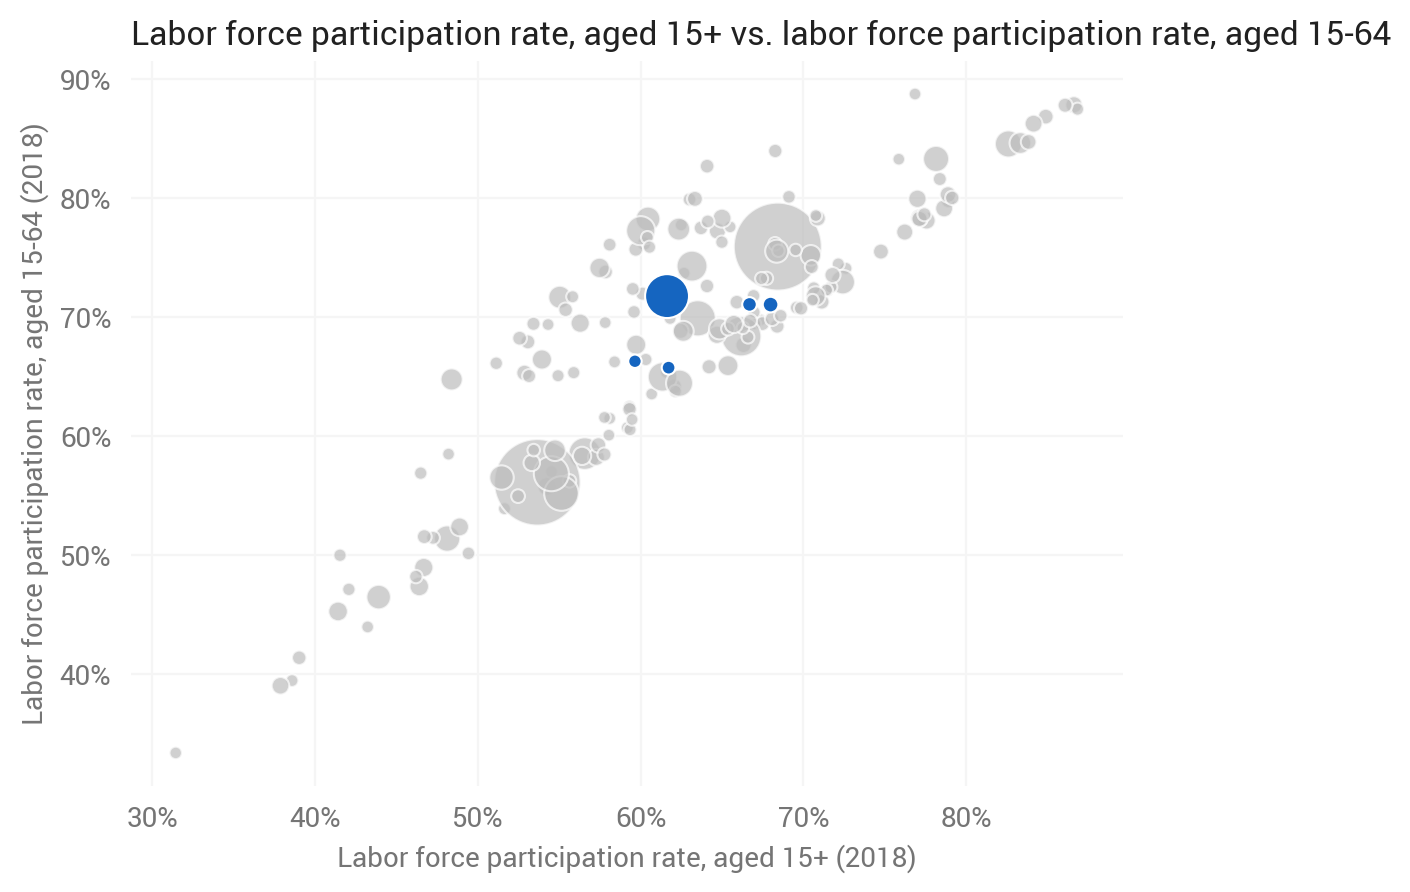

In [17]:
chart('lfpr', 'lfpr1564', True)
chart('lfpr', 'lfpr1564', False)

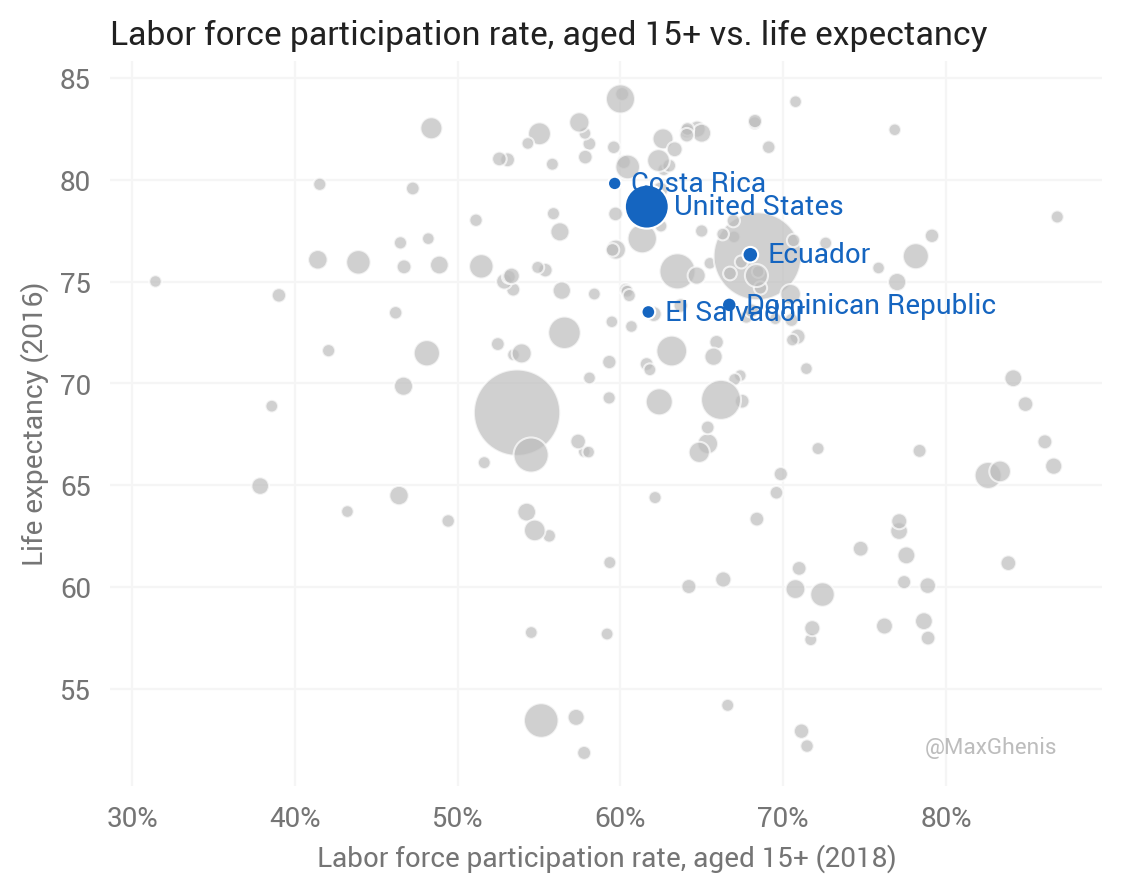

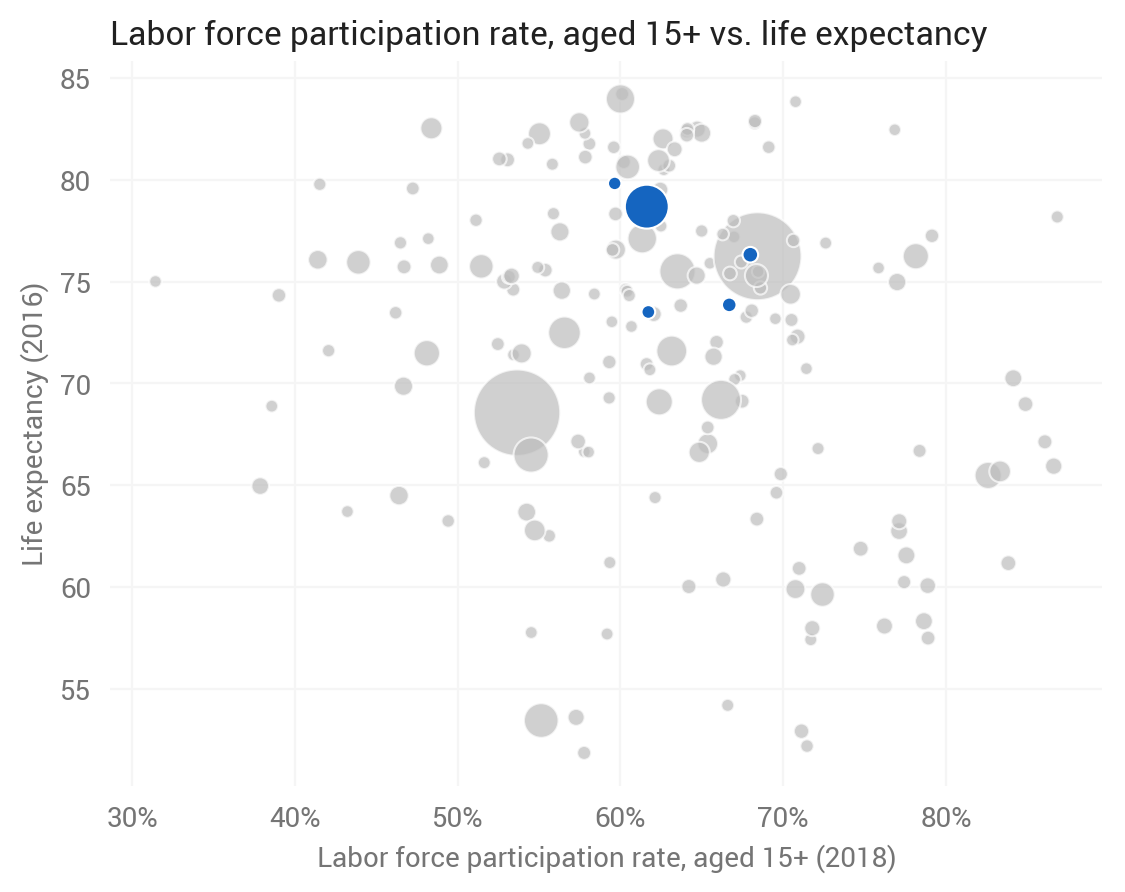

In [18]:
chart('lfpr', 'life_expectancy', True)
chart('lfpr', 'life_expectancy', False)

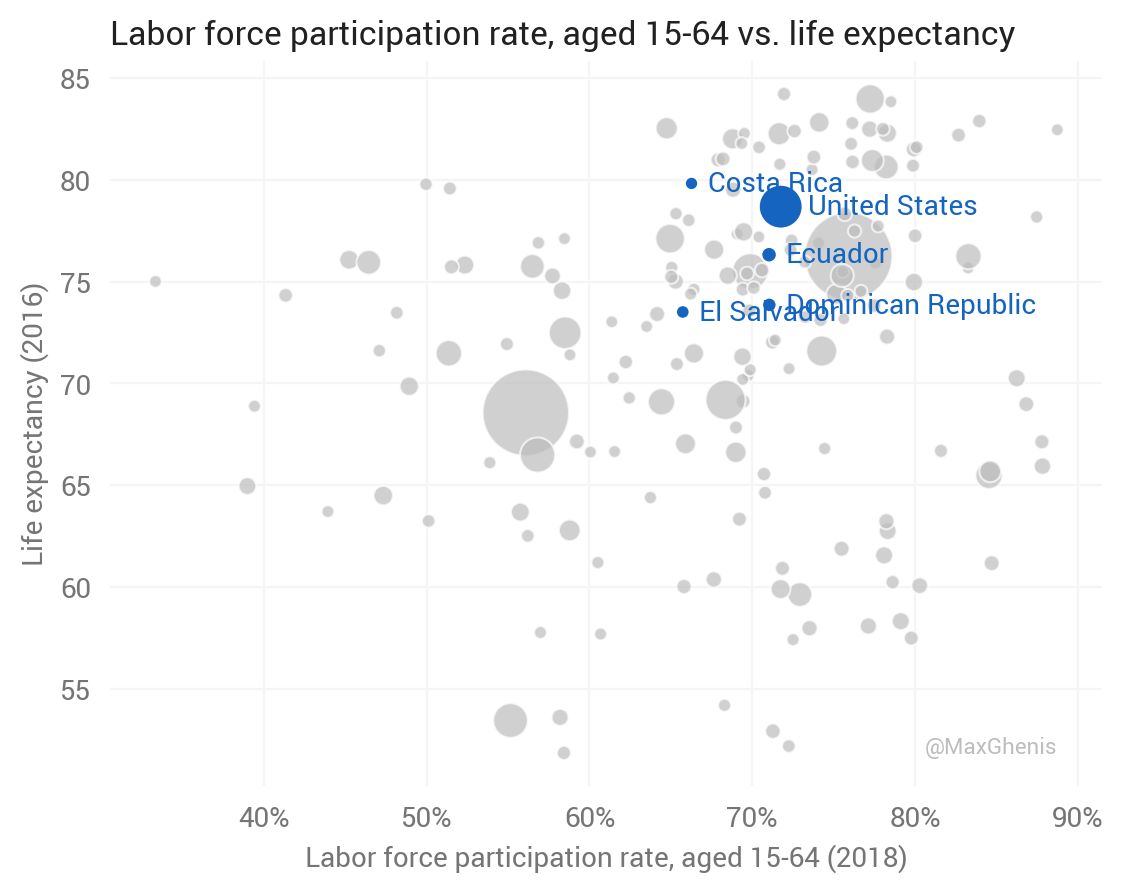

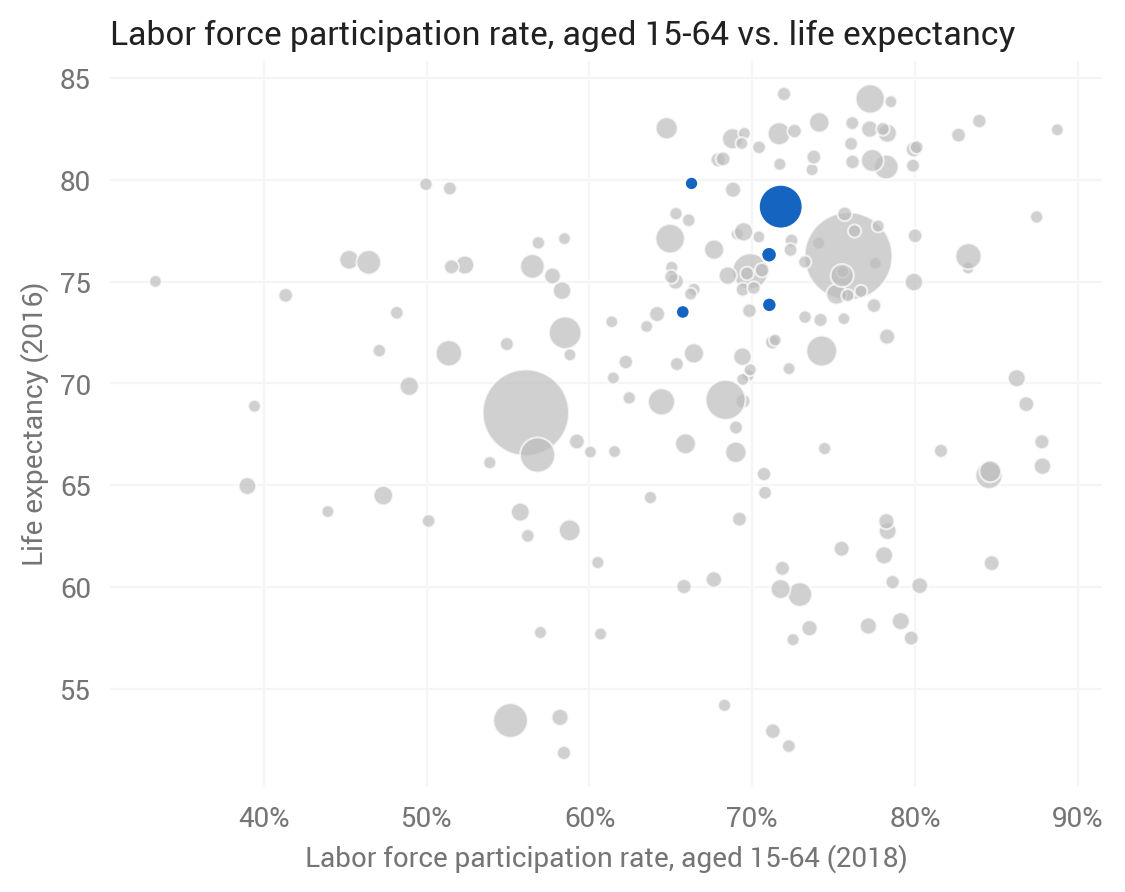

In [19]:
chart('lfpr1564', 'life_expectancy', True)
chart('lfpr1564', 'life_expectancy', False)

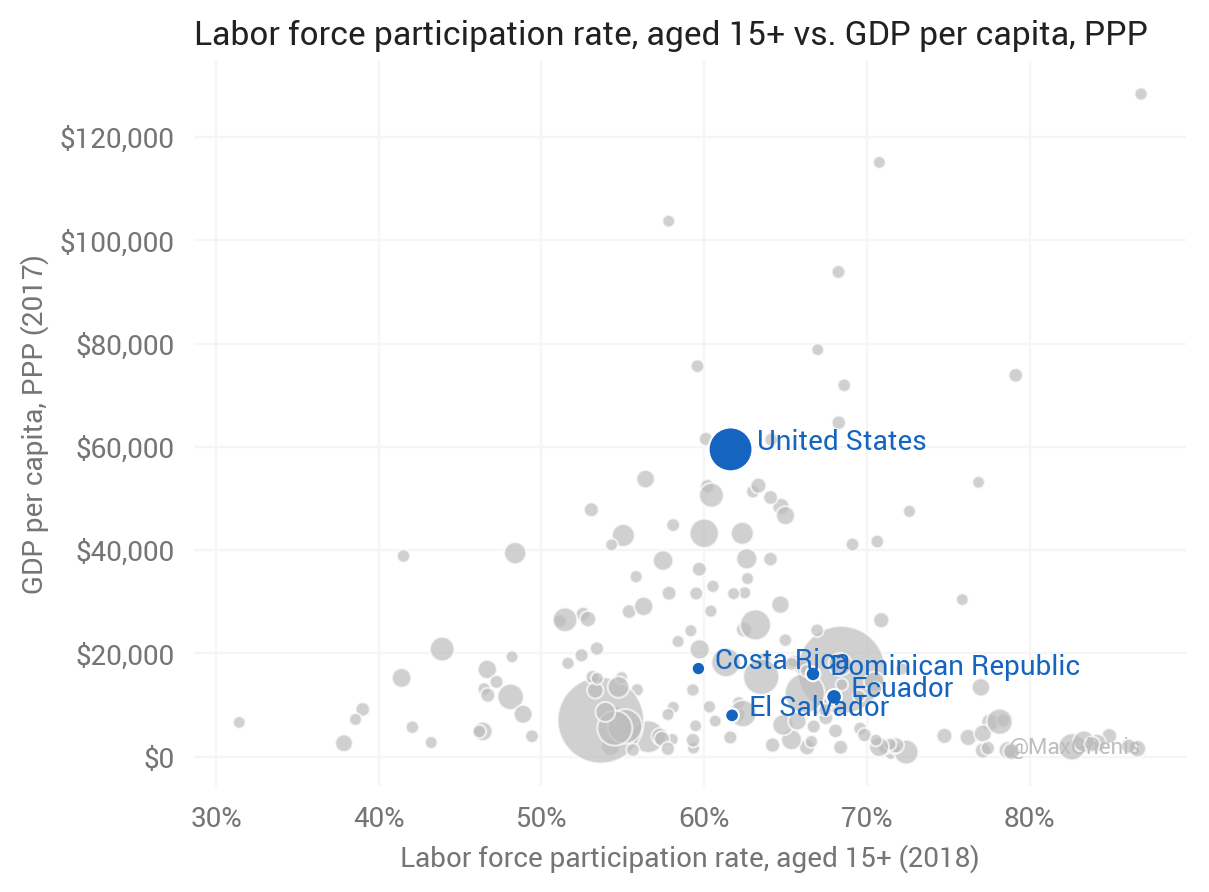

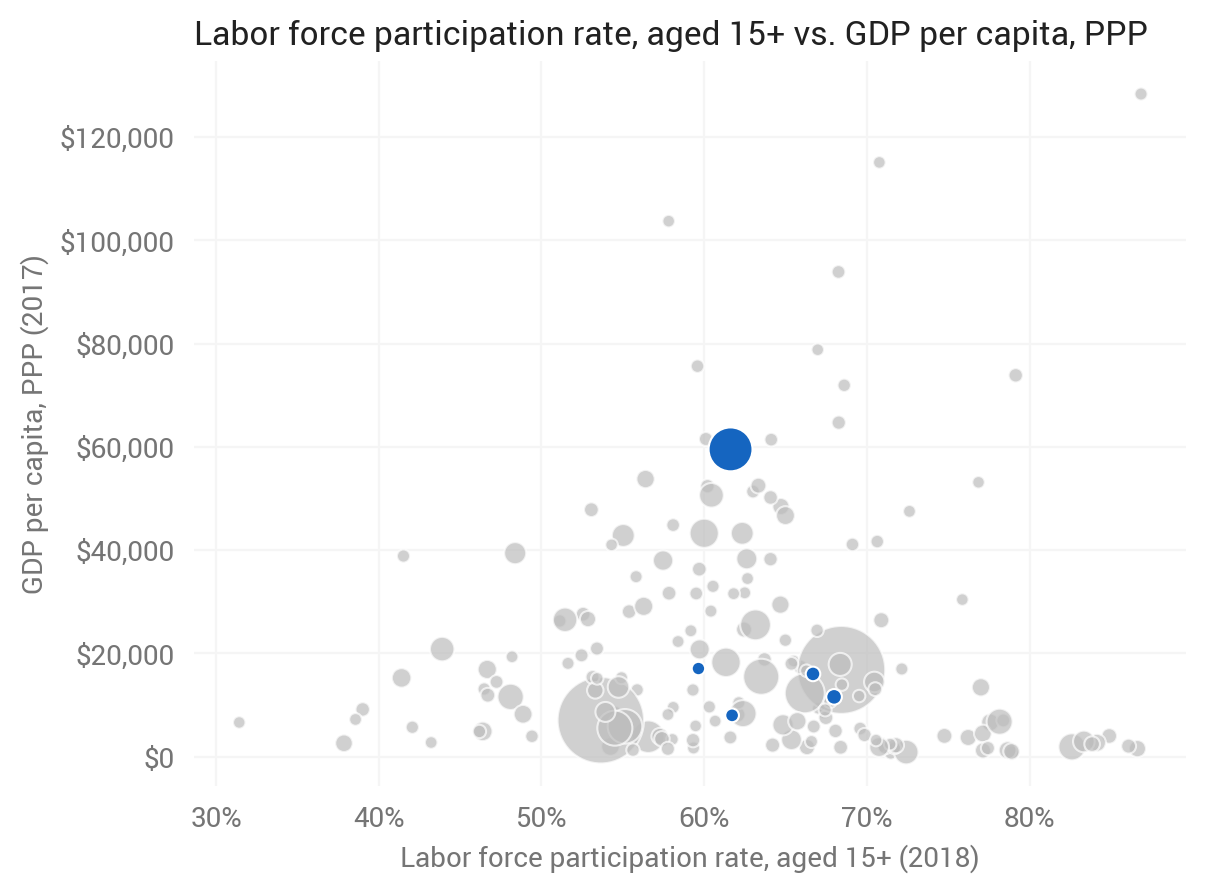

In [20]:
chart('lfpr', 'gdppcppp', True)
chart('lfpr', 'gdppcppp', False)

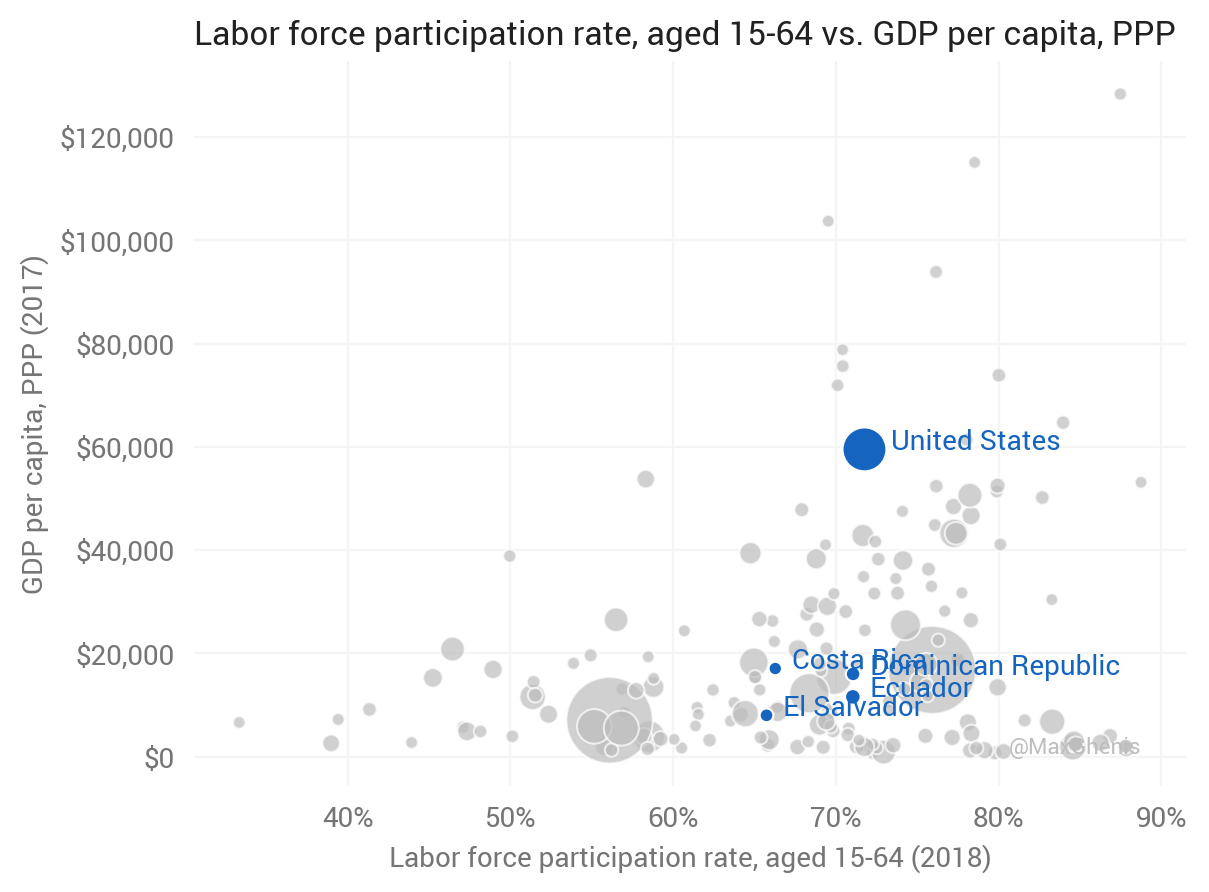

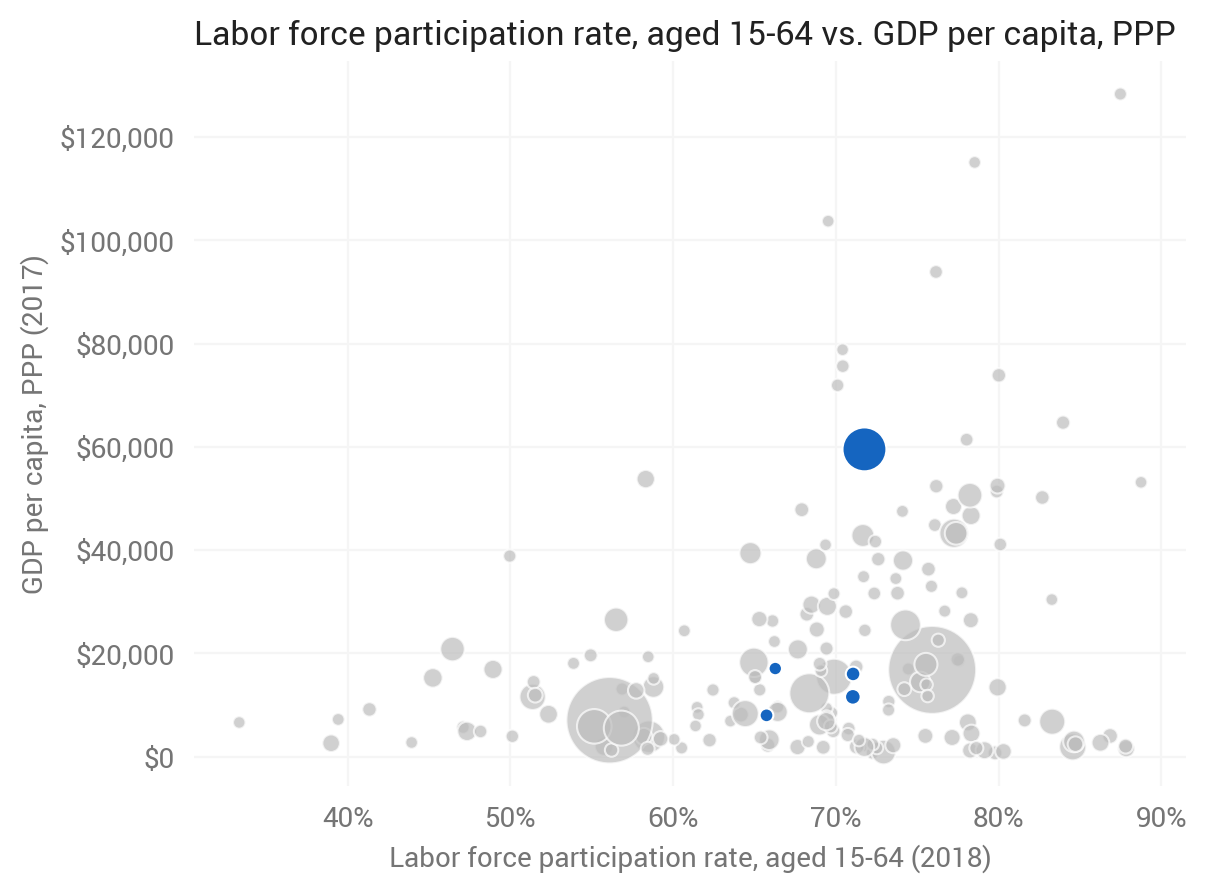

In [21]:
chart('lfpr1564', 'gdppcppp', True)
chart('lfpr1564', 'gdppcppp', False)

## What countries have most similar LFPR to US?

In [0]:
us = country[country.country == 'United States'].iloc[0]
country['lfpr_diff_us'] = np.abs(country.lfpr - us.lfpr)
country['lfpr1564_diff_us'] = np.abs(country.lfpr1564 - us.lfpr1564)

In [42]:
country.sort_values('lfpr_diff_us').head(30)

,country,gdppcppp,lfpr,lfpr1564,life_expectancy,pop,is_target,alpha,lfpr_diff_us,lfpr1564_diff_us,intercept,lfpr_pr,lfpr_rank
206,United States,59531.661964,61.620998,71.750999,78.690244,325719178.0,True,1.0,0.000000,0.000000,1,0.459770,80.0
107,Kyrgyz Republic,3725.541023,61.610001,65.374001,70.951220,6201500.0,False,0.7,0.010998,6.376999,1,0.454023,79.0
59,El Salvador,8006.059225,61.716000,65.733002,73.512000,6377853.0,True,1.0,0.095001,6.017998,1,0.465517,81.0
196,Trinidad and Tobago,31577.672999,61.810001,69.875999,70.673000,1369125.0,False,0.7,0.189003,1.875000,1,0.471264,82.0
128,Mexico,18273.482183,61.341999,64.956001,77.118000,129163276.0,False,0.7,0.278999,6.794998,1,0.448276,78.0
80,Guatemala,8150.253377,62.049999,64.158997,73.409000,16913503.0,False,0.7,0.429001,7.592003,1,0.477011,83.0
137,Namibia,10448.705947,62.131001,63.745998,64.388000,2533794.0,False,0.7,0.510002,8.005001,1,0.482759,84.0
205,United Kingdom,43268.783556,62.340000,77.384003,80.956098,66022273.0,False,0.7,0.719002,5.633003,1,0.488506,85.0
155,Philippines,8342.804479,62.387001,64.427002,69.094000,104918090.0,False,0.7,0.766003,7.323997,1,0.494253,86.0
40,Chile,24634.970210,62.451000,68.822998,79.522000,18054726.0,False,0.7,0.830002,2.928001,1,0.500000,87.0


In [24]:
country.sort_values('lfpr1564_diff_us').head(10)

,country,gdppcppp,lfpr,lfpr1564,life_expectancy,pop,is_target,alpha,lfpr_diff_us,lfpr1564_diff_us
206,United States,59531.661964,61.620998,71.750999,78.690244,325719178.0,True,1.0,0.000000,0.000000
202,Uganda,1864.224584,70.754997,71.747002,59.889000,42862958.0,False,0.7,9.133999,0.003998
151,Panama,24468.941075,66.939003,71.777000,78.001000,4098587.0,False,0.7,5.318005,0.026001
174,Slovenia,34868.214280,55.818001,71.697998,80.775610,2066748.0,False,0.7,5.802998,0.053001
68,France,42850.386280,55.028000,71.654999,82.273171,67118648.0,False,0.7,6.592999,0.096001
20,Benin,2271.675412,70.984001,71.858002,60.907000,11175692.0,False,0.7,9.363003,0.107002
86,"Hong Kong SAR, China",61540.158311,60.106998,71.956001,84.226829,7391700.0,False,0.7,1.514000,0.205002
209,Vanuatu,3207.831231,70.564003,71.415001,72.133000,276244.0,False,0.7,8.943005,0.335999
38,Chad,1941.175568,71.127998,71.271004,52.903000,14899994.0,False,0.7,9.507000,0.479996
37,Central African Republic,725.945420,71.468002,72.248001,52.171000,4659080.0,False,0.7,9.847004,0.497002


## Regressions

In [0]:
country['intercept'] = 1

In [0]:
def wls_coef(y, x):
    m = sm.WLS(country[y], country[['intercept', x]], 
               country['pop']).fit()
    return pd.DataFrame({'x': x,
                         'y': y,
                         'coef': [m.params[x]],
                         'p': [m.pvalues[x]]})    

In [27]:
pd.concat([wls_coef('life_expectancy', 'lfpr'),
           wls_coef('life_expectancy', 'lfpr1564'),
           wls_coef('gdppcppp', 'lfpr'),
           wls_coef('gdppcppp', 'lfpr1564')
          ])[['x', 'y', 'coef', 'p']]

,x,y,coef,p
0,lfpr,life_expectancy,0.010346,0.855654
0,lfpr1564,life_expectancy,0.235874,0.000001
0,lfpr,gdppcppp,-56.439429,0.672900
0,lfpr1564,gdppcppp,476.861815,0.000034


## Changes since x

Life expectancy, 